In [14]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (20, 8)})

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler)
from sklearn.pipeline import Pipeline

# Regressor
from sklearn.linear_model import (LinearRegression,
                                  Lasso,
                                  Ridge,
                                  ElasticNet)

# Metrics
from sklearn.metrics import mean_squared_error

# Set display options
pd.options.display.float_format = "{:.4f}".format
pd.set_option('display.max_columns', 100)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Load nifty index data
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv', 
                 index_col=0,
                 dayfirst=True)

# Descriptive statistics
df.describe()


,Open,High,Low,Close,Volume
count,2719.0000,2719.0000,2719.0000,2719.0000,2719.0000
mean,10124.8980,10175.2921,10057.4698,10117.5710,289222065.6433
std,3709.6071,3725.5270,3685.3052,3706.9455,195276778.8519
min,4640.2000,4645.9500,4588.0500,4636.7500,2826000.0000
25%,7637.0000,7681.0000,7581.6500,7623.8000,159178008.0000
50%,9376.9500,9431.9000,9301.3500,9351.8500,219496064.0000
75%,11700.8500,11755.1250,11631.3250,11684.0000,340908832.0000
max,18871.9500,18887.6000,18778.2000,18812.5000,1810971008.0000


In [16]:
# Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [17]:
# Create features
def create_features(frame):
    df = frame.copy()
    multiplier = 2
    
    # Features
    df['OC'] = df['Close'] / df['Open'] - 1
    df['HC'] = df['High'] / df['Low'] - 1
    df['GAP'] = df['Open'] / df['Close'].shift(1) - 1
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
    
    for i in [7, 14, 28]:
        df['PCHG' +  str(i)] = df['Close'].pct_change(i)
        df['VCHG' +  str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC' + str(i)] = df['OC'].rolling(i).mean()
        df['HC' + str(i)] = df['HC'].rolling(i).mean()
        df['GAP' + str(i)] = df['GAP'].rolling(i).mean()
        df['STD' + str(i)] = df['RET'].rolling(i).std()
        df['UB' + str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std()*multiplier
        df['LB' + str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std()*multiplier
        
    # Drop NaN values
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    
    return df

In [18]:
# Features
df1 = create_features(df)
display(df1.shape)

# Verify the output
df1.head(2)

(2690, 38)

,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,LB7,PCHG14,VCHG14,RET14,MA14,VMA14,OC14,HC14,GAP14,STD14,UB14,LB14,PCHG28,VCHG28,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,0.0275,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,5442.1990,5259.1296,0.0660,0.0195,0.0639,1.0249,1.0192,0.0020,0.0142,0.0026,0.0107,5486.1450,5015.7836,0.1606,1.0777,0.1490,1.0646,1.0967,0.0029,0.0138,0.0024,0.0104,5509.5275,4600.9761,5390.2000
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,0.0226,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,5428.6264,5307.0736,0.0682,0.1478,0.0659,1.0217,0.8150,0.0018,0.0146,0.0030,0.0106,5489.4954,5061.5689,0.1311,0.2383,0.1232,1.0616,0.8783,0.0023,0.0135,0.0022,0.0094,5534.1504,4620.9889,5416.0500


In [19]:
# Label
y = np.array(df1['Label'])
y

array([ 5390.2 ,  5416.05,  5531.95, ..., 18122.5 , 18191.  , 18105.3 ])

Text(0.5, 1.0, 'Features Set Correlations')

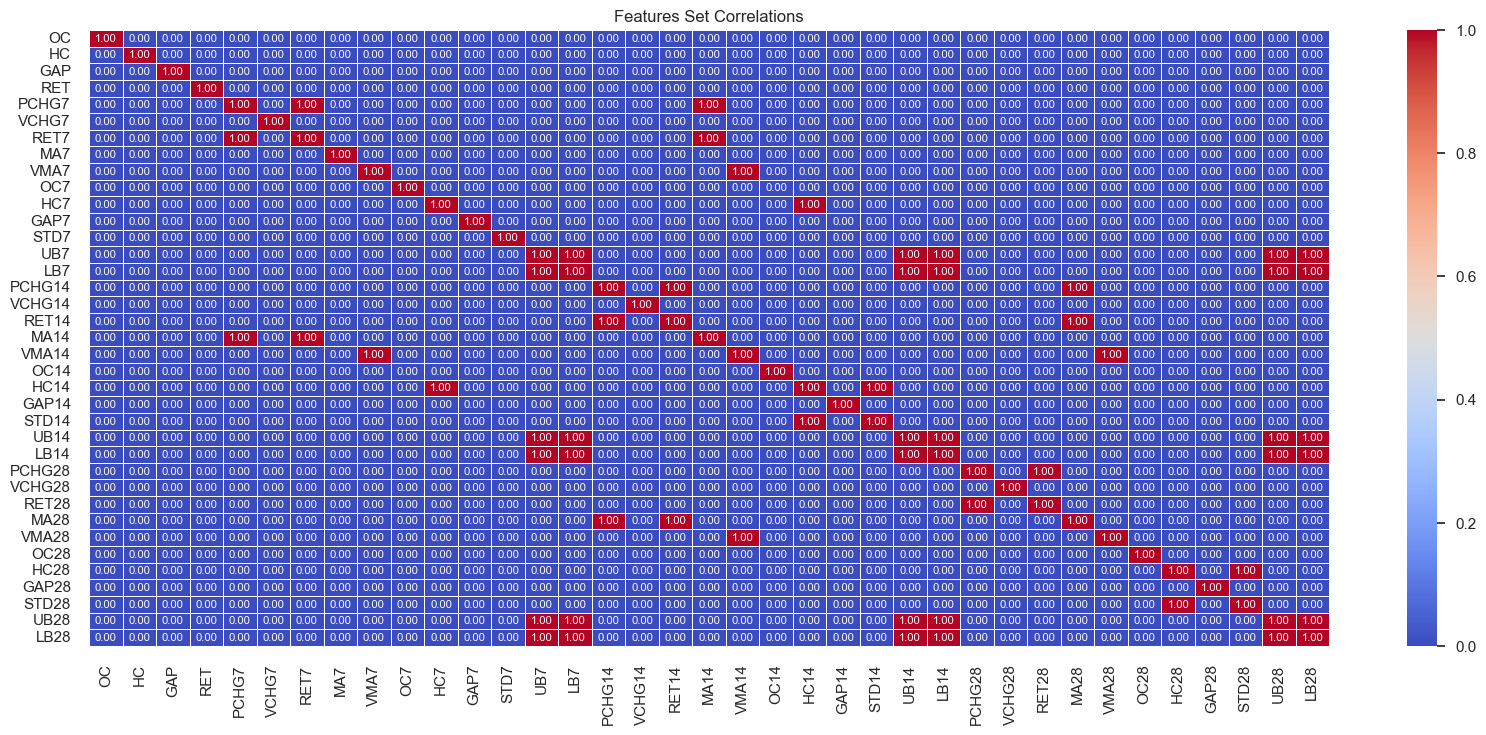

In [20]:
# Drop label from Data Frame
df1.drop('Label', axis=1, inplace=True)

# Remove features that are highly correlated
sns.heatmap(df1.corr() > 0.9,
            annot=True,
            annot_kws={'size': 8},
            fmt=".2f",
            linewidths=.5,
            cmap='coolwarm',
            cbar=True)

plt.title('Features Set Correlations')


In [21]:
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    
    return col_corr

In [22]:
# Total correlated features
drop_correlated_features = correlated_features(df1)

# Drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)

# Record feature names
feature_names = X.columns

# Display the new features set
X

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
10/02/2012,-0.0034,0.0162,-0.0023,-0.0057,0.0279,-0.0406,1.0058,0.9455,0.0008,0.0145,0.0032,0.0065,5442.1990,0.0660,0.0195,0.0020,0.0026,0.1606,1.0777,0.0029,0.0138,0.0024
13/02/2012,0.0015,0.0130,0.0001,0.0016,0.0228,-0.4628,1.0042,0.8406,0.0011,0.0146,0.0022,0.0064,5428.6264,0.0682,0.1478,0.0018,0.0030,0.1311,0.2383,0.0023,0.0135,0.0022
14/02/2012,0.0066,0.0093,-0.0017,0.0048,0.0169,-0.0734,1.0066,0.9424,0.0006,0.0138,0.0018,0.0057,5438.1094,0.0563,-0.0030,0.0014,0.0026,0.1403,0.2138,0.0027,0.0134,0.0020
15/02/2012,0.0131,0.0149,0.0082,0.0212,0.0318,0.4616,1.0235,1.3794,0.0030,0.0143,0.0015,0.0091,5529.6862,0.0724,0.4343,0.0022,0.0028,0.1646,0.7675,0.0032,0.0136,0.0023
16/02/2012,0.0015,0.0087,-0.0033,-0.0018,0.0350,0.4904,1.0166,1.1224,0.0053,0.0131,-0.0003,0.0086,5566.1259,0.0610,0.2507,0.0025,0.0018,0.1615,0.5339,0.0030,0.0131,0.0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.0095,0.0152,-0.0083,-0.0178,-0.0457,0.0645,0.9767,1.1157,-0.0050,0.0132,-0.0017,0.0085,18669.0039,-0.0478,-0.2321,-0.0025,-0.0010,-0.0324,-0.1175,-0.0009,0.0090,-0.0003
26/12/2022,0.0103,0.0174,0.0013,0.0116,-0.0217,-0.0354,0.9912,0.8942,-0.0020,0.0136,-0.0011,0.0103,18604.7406,-0.0337,-0.1888,-0.0019,-0.0005,-0.0215,-0.1944,-0.0005,0.0094,-0.0002
27/12/2022,0.0023,0.0101,0.0042,0.0065,-0.0075,-0.2283,0.9987,1.1366,-0.0013,0.0136,0.0002,0.0106,18577.5673,-0.0231,0.0686,-0.0014,-0.0002,-0.0115,0.0685,-0.0004,0.0096,0.0000
28/12/2022,0.0021,0.0058,-0.0026,-0.0005,-0.0162,0.2520,1.0005,0.9989,-0.0020,0.0129,-0.0003,0.0098,18464.3870,-0.0262,-0.0441,-0.0014,-0.0004,-0.0101,-0.0248,-0.0002,0.0094,-0.0001


In [23]:
# Decide which scaling to use
X.describe()

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,GAP7,STD7,UB7,PCHG14,VCHG14,OC14,GAP14,PCHG28,VCHG28,OC28,HC28,GAP28
count,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000,2690.0000
mean,-0.0007,0.0119,0.0012,0.0005,0.0036,0.1016,1.0014,1.0024,-0.0007,0.0119,0.0012,0.0090,10363.3054,0.0074,0.1658,-0.0007,0.0012,0.0153,0.1229,-0.0007,0.0119,0.0012
std,0.0089,0.0082,0.0063,0.0108,0.0283,1.9471,0.0147,0.2179,0.0030,0.0061,0.0026,0.0058,3755.5770,0.0405,4.8659,0.0021,0.0020,0.0566,2.2287,0.0015,0.0050,0.0014
min,-0.0682,0.0025,-0.0914,-0.1390,-0.2294,-0.9925,0.8703,0.0094,-0.0159,0.0050,-0.0287,0.0014,4937.6487,-0.3164,-0.9904,-0.0108,-0.0205,-0.3675,-0.9919,-0.0072,0.0059,-0.0100
25%,-0.0051,0.0073,-0.0010,-0.0046,-0.0119,-0.1811,0.9930,0.8633,-0.0025,0.0087,0.0002,0.0058,7849.8332,-0.0138,-0.1996,-0.0018,0.0004,-0.0164,-0.2094,-0.0015,0.0091,0.0005
50%,-0.0005,0.0100,0.0015,0.0007,0.0053,0.0021,1.0029,0.9701,-0.0006,0.0107,0.0013,0.0080,9681.1755,0.0092,-0.0056,-0.0006,0.0013,0.0187,-0.0117,-0.0006,0.0110,0.0013
75%,0.0039,0.0139,0.0039,0.0062,0.0198,0.2130,1.0103,1.1034,0.0012,0.0136,0.0024,0.0106,11955.6179,0.0312,0.2298,0.0006,0.0022,0.0513,0.2552,0.0003,0.0134,0.0020
max,0.0931,0.1875,0.0448,0.0840,0.1463,98.2647,1.0654,2.4288,0.0140,0.0904,0.0156,0.0735,18937.7871,0.1879,251.1766,0.0061,0.0131,0.2088,112.8719,0.0035,0.0536,0.0074


Text(0.5, 1.0, 'Boxplot of Features')

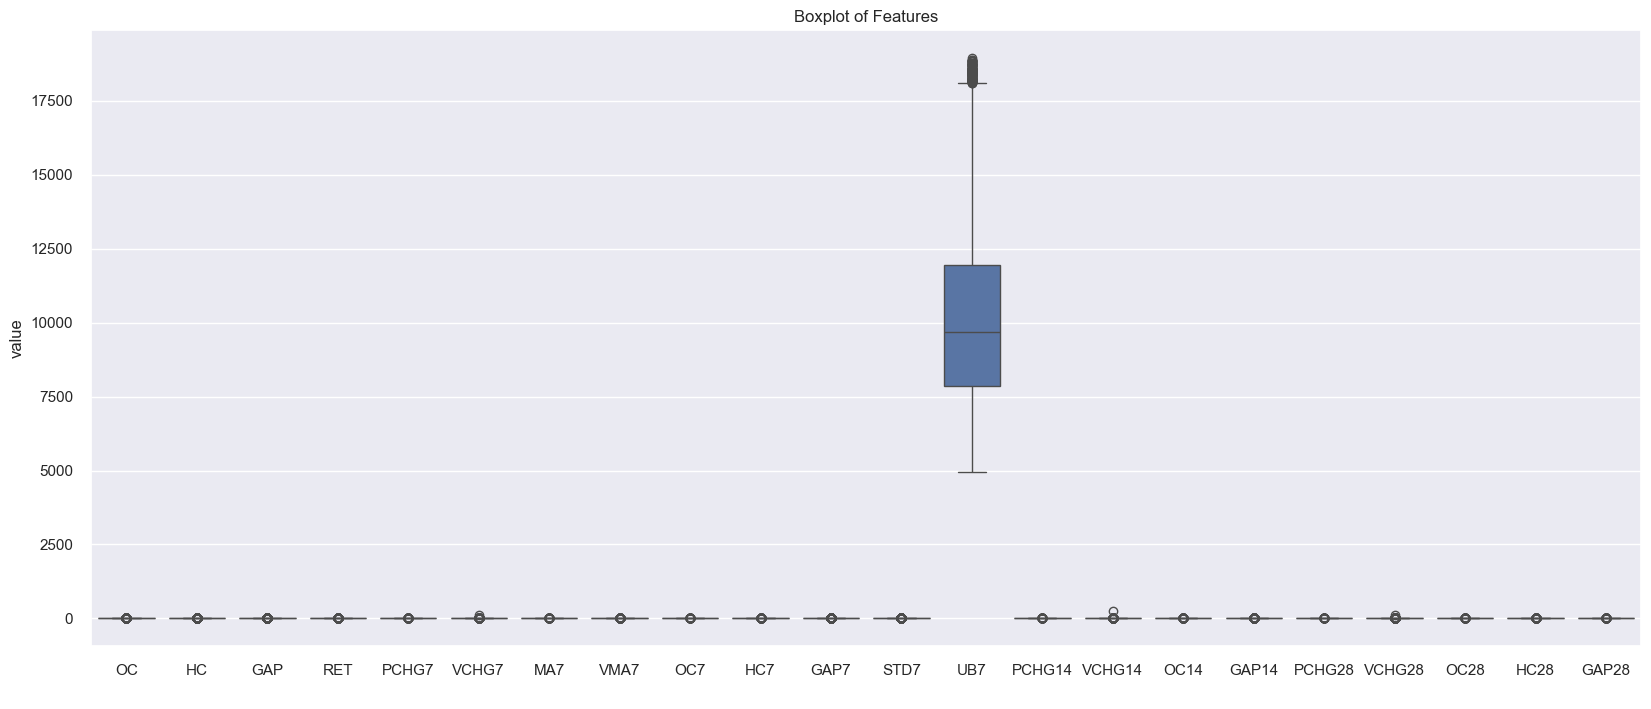

In [24]:
# Study the distribution
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features')

In [ ]:
class Regression:
    def __init__(self, X, y, testsize=0.20):
        
        self.X = X
        self.y = y
        self.testsize = testsize
    
        # Split training and testing dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=self.testsize,
                                                                                random_state=0,
                                                                                shuffle=False)
        
    # Fit and predict
    def fit_predict(self, estimator, transformer, alpha=None, l1_ratio=None):
        
        try:
            # Subsume estimators and transformers into a pipeline
            model = Pipeline([('scaler', transformer),
                              ('regressor', estimator)])
            
            # Fit/train model
            model.fit(self.X_train, self.y_train)
            
            # Predict labels
            y_pred = model.predict(self.X_test)
            
        except Exception as e:
            print(str(e))
        
        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred
    
    # Evaluate metrics
    def eval_metrics(self, model, y_pred):
        
        # Evaluate metrics
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)
        
        return mse, rmse, r2train, r2test
    
    # Plot coefficients as a function of lambda